In [2]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os 
from copy import deepcopy
from collections import defaultdict

In [4]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [5]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        if len(formula_splitted) == 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [6]:
convert_sbml_to_network('BIOMD0000000365_url.xml')

number reactions 33
number species 30


In [7]:
description

{'species': ['APC',
  'Va',
  'Va_APC',
  'Va3',
  'Va3_APC',
  'Va5',
  'Va5_APC',
  'Va53',
  'Va53_APC',
  'Va56',
  'Va56_APC',
  'Va36',
  'Va36_APC',
  'Va536',
  'Va536_APC',
  'HC',
  'LC',
  'HC5',
  'HC3',
  'HC56',
  'HC36',
  'HC536',
  'LC_APC',
  'HC53',
  'VaA3',
  'VaA53',
  'VaA36',
  'VaA536',
  'VaLCA1',
  'VaLCA1_APC'],
 'reactions': [['r1', 0, 1],
  ['r1revert', 0, 1],
  ['r2', 0, 1],
  ['r2revert', 0, 1],
  ['r3', 0, 1],
  ['r3revert', 0, 1],
  ['r4', 0, 1],
  ['r4revert', 0, 1],
  ['r5', 0, 1],
  ['r5revert', 0, 1],
  ['r6', 0, 1],
  ['r6revert', 0, 1],
  ['r7', 0, 1],
  ['r7revert', 0, 1],
  ['r8', 0, 1],
  ['r9', 0, 1],
  ['r10', 0, 1],
  ['r11', 0, 1],
  ['r12', 0, 1],
  ['r13', 0, 1],
  ['r14', 0, 1],
  ['r15', 0, 1],
  ['r16', 0, 1],
  ['r17', 0, 1],
  ['r17revert', 0, 1],
  ['r18', 0, 1],
  ['r18revert', 0, 1],
  ['r19', 0, 1],
  ['r19revert', 0, 1],
  ['r20', 0, 1],
  ['r20revert', 0, 1],
  ['r21', 0, 1],
  ['r21revert', 0, 1],
  ['r22', 0, 1],
  ['r22reve

In [8]:
complete_tests.simulate_until_convergence('BIOMD0000000365_url.xml', description['species'])

Converged at time 631.0


{'APC': 3.546913398862251e-10,
 'Va': 3.1704080236883953e-13,
 'Va_APC': 6.447772287999579e-15,
 'Va3': 2.270188723027305e-11,
 'Va3_APC': 4.983144247694436e-13,
 'Va5': 3.10042246093887e-08,
 'Va5_APC': 1.443871038730946e-09,
 'Va53': 5.4702606132154e-09,
 'Va53_APC': 3.990638649071227e-10,
 'Va56': 4.0280709495371367e-10,
 'Va56_APC': 1.9716891162137284e-11,
 'Va36': 1.1111254305140889e-14,
 'Va36_APC': 3.9075962862851663e-16,
 'Va536': 6.299005150009208e-11,
 'Va536_APC': 5.094040007113543e-12,
 'HC': 1.559961877597001e-10,
 'LC': 1.0074384899427296e-09,
 'HC5': 7.972209188549813e-10,
 'HC3': 1.8472715876329783e-12,
 'HC56': 4.144888910404914e-12,
 'HC36': 7.317283351653886e-16,
 'HC536': 6.24615795803972e-13,
 'LC_APC': 5.100333612989821e-11,
 'HC53': 9.860721143577501e-11,
 'VaA3': 2.818247204880957e-09,
 'VaA53': 1.562749534774247e-07,
 'VaA36': 1.1184711894237083e-12,
 'VaA536': 1.015675610274218e-09,
 'VaLCA1': 1.5238394044125598e-07,
 'VaLCA1_APC': 7.726054322513452e-09}

In [7]:
def alter_pathway(filename, reaction_number, parameter_number, output_filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    reaction = model.getReaction(reaction_number)
    kinetic_law = reaction.getKineticLaw()
    parameter = kinetic_law.getParameter(parameter_number)
    parameter.setValue(parameter.getValue() * 100)
    
    modified_sbml = libsbml.writeSBML(document, output_filename)

In [10]:
def generate_test_set(filename, description):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    base_dir = 'altered_pathways'
    
    critical_reactions = ['v2', 'v4', 'v8', 'v16']
    
    i = 0
    num_reactions = model.getNumReactions()
    for j in range(num_reactions):
        reaction = model.getReaction(j)
        print('Considering reaction: ', reaction.getId(), ' value of i: ', i)
        if reaction.getId() in critical_reactions :
            kinetic_law = reaction.getKineticLaw()
            num_parameters = kinetic_law.getNumParameters()
            if reaction.getId() == 'v2':
                print('Skipping')
                i+= 2
            else:
                i+= 1
            continue
        kinetic_law = reaction.getKineticLaw()
        num_parameters = kinetic_law.getNumParameters()
        for k in range(num_parameters):
            parameter = kinetic_law.getParameter(k)
            print('altering: ', description['reactions'][i][0], ' from sbml: ', reaction.getId(), parameter.getId())

            os.makedirs(os.path.join(base_dir, 'reaction' + str(i)), exist_ok=True)
            alteration_dir = os.path.join(base_dir, 'reaction' + str(i), 'reaction_' + str(i) + '_100x.xml')
            alter_pathway('BIOMD0000000359_url.xml', j, k, alteration_dir)
            
            altered_description = deepcopy(description)
            altered_description['altered'] = altered_description['reactions'][i][0]
            description_dir = os.path.join(base_dir, 'reaction' + str(i), 'description')
            description_file = open(description_dir, 'wb')
            pickle.dump(altered_description, description_file)
            description_file.close()
            i += 1

In [11]:
generate_test_set('BIOMD0000000359_url.xml', description)

Considering reaction:  reaction_1  value of i:  0
altering:  reaction_1  from sbml:  reaction_1 k1
altering:  reaction_1revert  from sbml:  reaction_1 k2
Considering reaction:  reaction_2  value of i:  2
altering:  reaction_2  from sbml:  reaction_2 k1
Considering reaction:  reaction_3  value of i:  3
altering:  reaction_3  from sbml:  reaction_3 k1
altering:  reaction_3revert  from sbml:  reaction_3 k2
Considering reaction:  reaction_4  value of i:  5
altering:  reaction_4  from sbml:  reaction_4 k1
altering:  reaction_4revert  from sbml:  reaction_4 k2
Considering reaction:  reaction_5  value of i:  7
altering:  reaction_5  from sbml:  reaction_5 k1
altering:  reaction_5revert  from sbml:  reaction_5 k2
Considering reaction:  reaction_6  value of i:  9
altering:  reaction_6  from sbml:  reaction_6 k1
altering:  reaction_6revert  from sbml:  reaction_6 k2
Considering reaction:  reaction_9  value of i:  11
altering:  reaction_9  from sbml:  reaction_9 k1
altering:  reaction_9revert  fr

In [12]:
description_path = 'altered_pathways/reaction5/description'
description_file = open(description_path, 'rb')
temp = pickle.load(description_file)
description_file.close()
temp

{'species': ['VIIa_TF',
  'X',
  'VIIa_TF_X',
  'VIIa_TF_Xa',
  'Xa',
  'TFPI',
  'Xa_TFPI',
  'Xa_TFPI_VIIa_TF',
  'VIIa_TF_Xa_TFPI'],
 'reactions': [['reaction_1', 0, 1],
  ['reaction_1revert', 0, 1],
  ['reaction_2', 0, 1],
  ['reaction_3', 0, 1],
  ['reaction_3revert', 0, 1],
  ['reaction_4', 0, 1],
  ['reaction_4revert', 0, 1],
  ['reaction_5', 0, 1],
  ['reaction_5revert', 0, 1],
  ['reaction_6', 0, 1],
  ['reaction_6revert', 0, 1],
  ['reaction_9', 0, 1],
  ['reaction_9revert', 0, 1],
  ['reaction_8', 0, 1],
  ['reaction_8revert', 0, 1]],
 'connections': [['X', 'reaction_1'],
  ['reaction_1revert', 'X'],
  ['VIIa_TF', 'reaction_1'],
  ['reaction_1revert', 'VIIa_TF'],
  ['reaction_1', 'VIIa_TF_X'],
  ['VIIa_TF_X', 'reaction_1revert'],
  ['VIIa_TF_X', 'reaction_2'],
  ['reaction_2', 'VIIa_TF_Xa'],
  ['VIIa_TF_Xa', 'reaction_3'],
  ['reaction_3revert', 'VIIa_TF_Xa'],
  ['reaction_3', 'Xa'],
  ['Xa', 'reaction_3revert'],
  ['reaction_3', 'VIIa_TF'],
  ['VIIa_TF', 'reaction_3revert']

In [13]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000359_url.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )


    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 0, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Converged at time 3364.0
Converged at time 1534.0
reaction1  total species:  9 correct species:  7 ratio:  0.7777777777777778
Converged at time 3364.0
Min and max abs differences:  6.099324705467922e-16 1.2013856576231774e-10
reaction4  total species:  9 correct species:  7 ratio:  0.7777777777777778
Converged at time 3364.0
Converged at time 7422.0
reaction9  total species:  9 correct species:  4 ratio:  0.4444444444444444
Converged at time 3364.0
Converged at time 993.0
reaction2  total species:  9 correct species:  7 ratio:  0.7777777777777778
Converged at time 3364.0
Converged at time 3364.0
reaction11  total species:  9 correct species:  6 ratio:  0.6666666666666666
Converged at time 3364.0
Min and max abs differences:  1.656274398586507e-10 0.0023288449686305057
reaction13  total species:  9 correct species:  6 ratio:  0.6666666666666666
Converged at time 3364.0
Converged at time 1249.0
reaction7  total species:  9 correct species:  5 ratio:  0.5555555555555556
Converged at time 

In [14]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  135  correct:  86  uncertain:  0  true pos:  35  true neg:  51  false_pos:  33 false neg:  16


In [11]:
results_path = '../../../results/real_dataset/small_class/results2'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 182,
 'uncertain_species': 1,
 'correct_species': 151,
 'true_positives': 76,
 'false_positives': 17,
 'false_negatives': 13,
 'true_negatives': 75,
 'deltas_normal': [[-3584.0, 3.56923792846934e-29],
  [-3584.0, 3.56923792846934e-29],
  [2.876464418655189e-06, 1.05563494594709e-16],
  [2.876464418655189e-06, 1.05563494594709e-16],
  [945.7722970390278, 0.01414018094004984],
  [-945.7722970390618, 0.3095900927184679],
  [6.616437497966092, 0.1326734704369838],
  [-952.3887345370152, 0.009890061260518411],
  [0.000573871301867257, 4.919556735316632e-09],
  [0.000573871301867257, 4.919556735316632e-09],
  [-3072.0, 2.60611023348555e-29],
  [-7.759685636885004, 0.000768217154518248],
  [1.264735227170604, 2.5286051598997386e-08],
  [-1.26473522720255, 5.536217034704391e-07],
  [-1.6480795839157736e-08, 8.2317471099271765e-19],
  [-1.2647352106949938, 1.31336168294649e-05],
  [-1.6508014709304462, 1.4151625059872775e-05],
  [1024.0, 3.021577082302087e-30],
  [644.82157024

In [12]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives
for d in deltas_normal:
    partial_results['deltas_normal'].append(d)
for d in deltas_uncertain:
    partial_results['deltas_uncertain'].append(d)

In [7]:
partial_results

{'total_species': 219,
 'uncertain_species': 1,
 'correct_species': 169,
 'true_positives': 83,
 'false_positives': 28,
 'true_negatives': 86,
 'false_negatives': 21,
 'deltas_normal': [[-6.030874584450618e-19, 3.7797831254827617e-28],
  [-9.261225017100387e-18, 2.121134249077894e-07],
  [-6.107026571629593e-18, 7.100705536888796e-09],
  [2.1184196746671993e-11, 4.488244696711082e-10],
  [1.663835789970094e-17, 3.45636591125853e-09],
  [2.67493838448983e-12, 6.231110762566772e-07],
  [-6.848109319489976e-19, 1.600163002102306e-10],
  [-2.6749217583646586e-12, 7.186020513047235e-14],
  [-2.118420659172407e-11, 0.009900000124251435],
  [-5.974175566166669e-19, 1.2670273033253126e-13],
  [-2.757728534462725e-14, 7.913726655884219e-19],
  [-4.2744462067384806e-13, 0.009789929764395576],
  [-8.418829605185009e-12, 0.009788663811258645],
  [2.049369974906953e-11, 4.2004252657546e-10],
  [5.0771241353288305e-11, 0.01054695354705196],
  [-4.193021212285844e-08, 0.009767394925808866],
  [-4.189

In [13]:
results_path = '../../../results/real_dataset/small_class/results2'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [3]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.6111111111111112


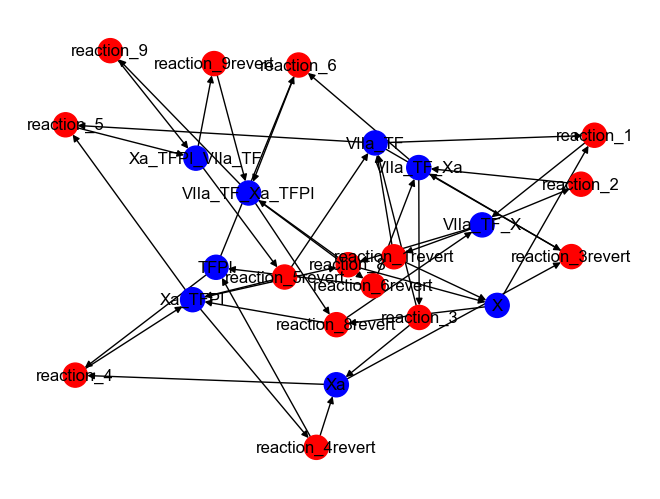

In [7]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [8]:
description_path = 'description_reaction_1_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

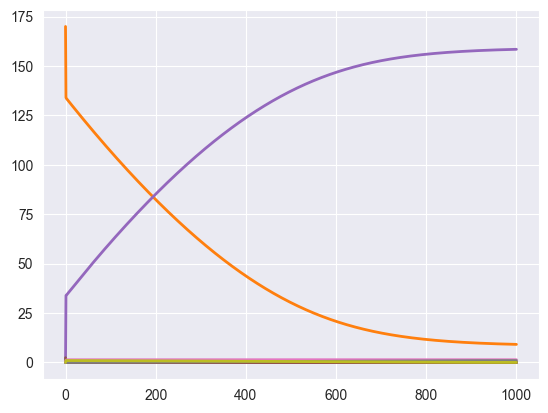

       time,   [VIIa_TF],     [X], [VIIa_TF_X], [VIIa_TF_Xa],    [Xa],     [TFPI], [Xa_TFPI], [Xa_TFPI_VIIa_TF], [VIIa_TF_Xa_TFPI]
 [[       0,           1,     170,           0,            0,       0,        2.4,         0,                 0,                 0],
  [   1.001,  0.00648807, 134.081,  0.00360852,    0.0034328,  33.917,   0.404783,   1.00875,         0.0134857,          0.972985],
  [   2.002,  0.00129979, 133.583, 0.000713786,  0.000702299, 34.0997,  0.0842489,   1.31847,         0.0145877,          0.982696],
  [   3.003,  0.00125317, 133.291, 0.000686065,  0.000679008, 34.3423,  0.0344863,   1.36813,         0.0153419,           0.98204],
  [   4.004,  0.00124828, 133.004, 0.000681822,  0.000677884, 34.6217,  0.0266501,   1.37596,         0.0160978,          0.981294],
  [ 5.00501,  0.00124878, 132.717,  0.00068061,  0.000679631, 34.9067,  0.0252805,   1.37733,         0.0168548,          0.980536],
  [ 6.00601,   0.0012501, 132.431, 0.000679854,  0.000681817, 35.1923, 

In [9]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000359.xml')

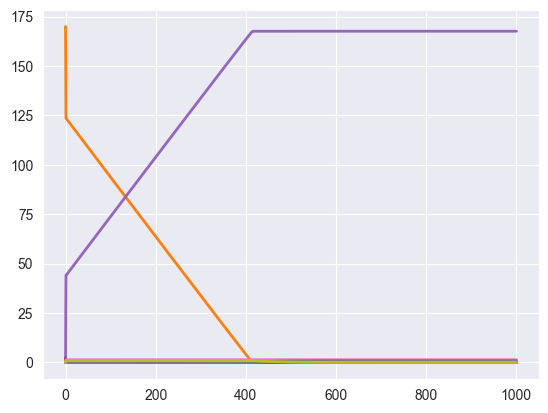

       time,   [VIIa_TF],          [X],  [VIIa_TF_X], [VIIa_TF_Xa],    [Xa],     [TFPI], [Xa_TFPI], [Xa_TFPI_VIIa_TF], [VIIa_TF_Xa_TFPI]
 [[       0,           1,          170,            0,            0,       0,        2.4,         0,                 0,                 0],
  [   1.001, 1.70231e-05,      123.649,  0.000867875,  0.000503815, 44.1773,   0.227499,   1.17389,        0.00014897,          0.998462],
  [   2.002, 1.44148e-05,      123.327,  0.000730246,  0.000428291, 44.3101,  0.0384991,   1.36267,       0.000157604,          0.998669],
  [   3.003, 1.42847e-05,      123.023,  0.000721649,  0.000423634, 44.5976,  0.0214412,   1.37972,       0.000166271,          0.998674],
  [   4.004, 1.43044e-05,       122.72,   0.00072084,   0.00042323, 44.8991,  0.0198104,   1.38135,       0.000174963,          0.998667],
  [ 5.00501, 1.43373e-05,      122.417,  0.000720712,  0.000423199, 45.2019,  0.0195486,   1.38161,       0.000183677,          0.998658],
  [ 6.00601, 1.43716e-05,    

In [11]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000359_reaction1_100x.xml')

In [12]:
species = description['species']
species

['VIIa_TF',
 'X',
 'VIIa_TF_X',
 'VIIa_TF_Xa',
 'Xa',
 'TFPI',
 'Xa_TFPI',
 'Xa_TFPI_VIIa_TF',
 'VIIa_TF_Xa_TFPI']

In [13]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [14]:
final_normal

[1.00000000e+03 3.50888112e-04 9.15435977e+00 1.31868348e-05
 3.68972618e-04 1.58448592e+02 3.33416972e-03 1.39739888e+00
 9.69932318e-01 2.93346315e-02]

In [15]:
temp = final_concentrations_normal[1]
temp

[  1.  170.    0.    0.    0.    2.4   0.    0.    0. ]

In [16]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

VIIa_TF
final normal:  0.0003508881120714806 final altered:  4.082577632796479e-07 delta:  -0.00035047985430820095 relative delta  -0.99883650158203 initial concentration:  1.0 delta1 0.00035047985430820095 delta2 0.99883650158203
X
final normal:  9.154359765849764 final altered:  2.475075771653977e-09 delta:  -9.154359763374687 relative delta  -0.9999999997296287 initial concentration:  170.0 delta1 0.05384917507867463 delta2 0.9999999997296287
VIIa_TF_X
final normal:  1.3186834762536773e-05 final altered:  4.1441700778436275e-16 delta:  -1.3186834762122355e-05 relative delta  -0.9999999999685734 initial concentration:  0.0 delta1 0 delta2 0.9999999999685735
VIIa_TF_Xa
final normal:  0.000368972618452971 final altered:  4.4463552020250635e-07 delta:  -0.0003685279829327685 relative delta  -0.998794936269074 initial concentration:  0.0 delta1 0 delta2 0.9987949362690739
Xa
final normal:  158.44859224263018 final altered:  167.60308647831798 delta:  9.154494235687793 relative delta  0.0

In [17]:
expected_results

{'VIIa_TF': 'unchanged',
 'X': 'decreased',
 'VIIa_TF_X': 'decreased',
 'VIIa_TF_Xa': 'decreased',
 'Xa': 'unchanged',
 'TFPI': 'unchanged',
 'Xa_TFPI': 'unchanged',
 'Xa_TFPI_VIIa_TF': 'unchanged',
 'VIIa_TF_Xa_TFPI': 'decreased'}

In [18]:
description['reactions']

[['reaction_1', 0, 1],
 ['reaction_1revert', 0, 1],
 ['reaction_2', 0, 1],
 ['reaction_3', 0, 1],
 ['reaction_3revert', 0, 1],
 ['reaction_4', 0, 1],
 ['reaction_4revert', 0, 1],
 ['reaction_5', 0, 1],
 ['reaction_5revert', 0, 1],
 ['reaction_6', 0, 1],
 ['reaction_6revert', 0, 1],
 ['reaction_9', 0, 1],
 ['reaction_9revert', 0, 1],
 ['reaction_8', 0, 1],
 ['reaction_8revert', 0, 1]]

In [19]:
description['reactions'][0][1] = 0.2

In [18]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [19]:
graph = graph_functions.generate_graph(description)

In [20]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'M': 0.5, 'MpY': 0.5, 'MpT': 0.5, 'Mpp': 0.5, 'MAPKK': 0.5, 'MKP': 0.5, 'MpY_MAPKK': 0.5, 'MpT_MAPKK': 0.5, 'M_MAPKK_Y': 0.5, 'M_MAPKK_T': 0.5, 'Mpp_MKP_Y': 0.5, 'Mpp_MKP_T': 0.5, 'MpY_MKP_Y': 0.5, 'MpY_MKP_T': 0.5, 'MpT_MKP_Y': 0.5, 'MpT_MKP_T': 0.5, 'M_MKP_T': 0.5, 'M_MKP_Y': 0.5}
Firing reaction  reaction_0000001
reactant:  M  delta:  0.0
reactant:  MAPKK  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.31049363849558864}
new reaction strength:  0.0  reaction weight:  0.31049363849558864  reaction strength  0.2
reactant:  M  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  MAPKK  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  M_MAPKK_Y new value:  0.6899744811276125
Firing reaction  reaction_0000001revert
reactant:  M_MAPKK_Y  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.678764660401966}
new reaction strength:  0.0  reaction weight:  0.678764660401966  reaction s

In [21]:
species_propagation

[{'M': 0.31002551887238755,
  'MpY': 0.5,
  'MpT': 0.5,
  'Mpp': 0.5,
  'MAPKK': 0.31002551887238755,
  'MKP': 0.5,
  'MpY_MAPKK': 0.5,
  'MpT_MAPKK': 0.5,
  'M_MAPKK_Y': 0.6899744811276125,
  'M_MAPKK_T': 0.5,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.5,
  'M_MKP_Y': 0.5},
 {'M': 0.6708783557279607,
  'MpY': 0.9422795106044548,
  'MpT': 0.8670982768741314,
  'Mpp': 0.5,
  'MAPKK': 0.5913580924001746,
  'MKP': 0.9290585038041786,
  'MpY_MAPKK': 0.08410755778349127,
  'MpT_MAPKK': 0.13290172312586868,
  'M_MAPKK_Y': 0.09475501814094794,
  'M_MAPKK_T': 0.025746483254046715,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.06570426290880449,
  'M_MKP_Y': 0.0761787294828381},
 {'M': 0.04762354052406159,
  'MpY': 0.44484555728100167,
  'MpT': 0.33842444463130605,
  'Mpp': 0.027778923927269716,
  'MAPKK': 0.03456896

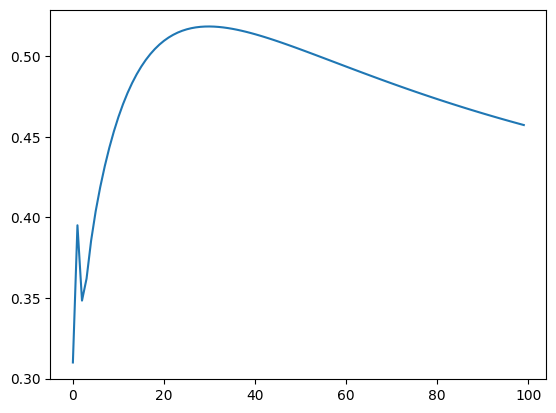

In [74]:
import matplotlib.pyplot as plt
concentrations = [conc['M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [75]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

M propagation results:  0.4573673063139326 simulation results:  increased
MpY propagation results:  0.5859506999350107 simulation results:  increased
MpT propagation results:  0.42683903449371147 simulation results:  increased
Mpp propagation results:  0.38758917256795355 simulation results:  unchanged
MAPKK propagation results:  0.4282587576580072 simulation results:  decreased
MKP propagation results:  0.5468037734808247 simulation results:  increased
MpY_MAPKK propagation results:  0.5034654849769683 simulation results:  unchanged
MpT_MAPKK propagation results:  0.4660739809818277 simulation results:  unchanged
M_MAPKK_Y propagation results:  0.5647061946329963 simulation results:  increased
M_MAPKK_T propagation results:  0.47072859983635107 simulation results:  unchanged
Mpp_MKP_Y propagation results:  0.4835596299636847 simulation results:  unchanged
Mpp_MKP_T propagation results:  0.4836623648528669 simulation results:  unchanged
MpY_MKP_Y propagation results:  0.534006843731000

In [2]:
res = complete_tests.complete_tests2(
            'BIOMD0000000359.xml',
            'BIOMD0000000359_reaction1_100x.xml',
            'description_reaction_1_altered',
            []
        )

In [3]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0)

Specie:  VIIa_TF expected result:  decreased
confidence interval:  [0.4654811606046535, 0.4676694955920385]
Specie:  X expected result:  decreased
confidence interval:  [0.4666392609481602, 0.46891619363133596]
Specie:  VIIa_TF_X expected result:  decreased
confidence interval:  [0.49716905013338714, 0.4976879379923808]
Specie:  VIIa_TF_Xa expected result:  decreased
confidence interval:  [0.5338932103688179, 0.5357113554145125]
Specie:  Xa expected result:  increased
confidence interval:  [0.5853407949468978, 0.5878132416217594]
Specie:  TFPI expected result:  decreased
confidence interval:  [0.4632318406142065, 0.4650206566217586]
Specie:  Xa_TFPI expected result:  decreased
confidence interval:  [0.5158841654058645, 0.5166479053520966]
Specie:  Xa_TFPI_VIIa_TF expected result:  increased
confidence interval:  [0.4990856077624481, 0.5002901465263283]
Specie:  VIIa_TF_Xa_TFPI expected result:  decreased
confidence interval:  [0.5088169071427805, 0.5100308742578546]


In [4]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  9 correct experiments:  5 ratio:  0.5555555555555556


In [31]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  M
 lower:  0.4637417533839022  higher:  0.4673349186799267
decrease, expected:  increased
specie:  MpY
 lower:  0.5991303309472806  higher:  0.6023748512798377
increase, expected:  increased
specie:  MpT
 lower:  0.4718955701272027  higher:  0.4759069512085346
decrease, expected:  increased
specie:  Mpp
 lower:  0.3756636941126044  higher:  0.3789976416682042
decrease, expected:  decreased
specie:  MAPKK
 lower:  0.3602388673451398  higher:  0.36140146766758047
decrease, expected:  decreased
specie:  MKP
 lower:  0.5607346855559303  higher:  0.5631176832807838
increase, expected:  increased
specie:  MpY_MAPKK
 lower:  0.489276800582603  higher:  0.49027261550261664
decrease, expected:  decreased
specie:  MpT_MAPKK
 lower:  0.4604340713427221  higher:  0.4614110647921208
decrease, expected:  decreased
specie:  M_MAPKK_Y
 lower:  0.552772153190489  higher:  0.5540794675295615
increase, expected:  increased
specie:  M_MAPKK_T
 lower:  0.455282023422336  higher:  0.456438765868962

<Axes: ylabel='Count'>

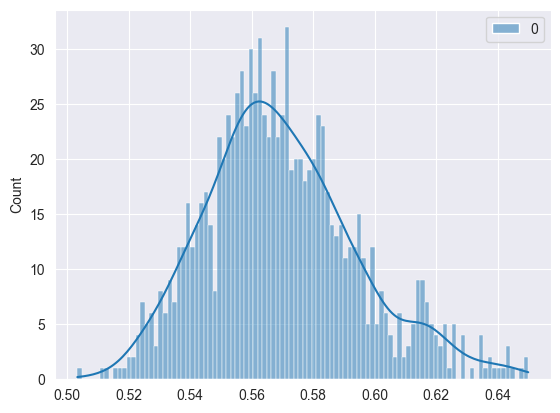

In [30]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['MpY_MKP_T'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)